# Predicting Mortgage Rates from Government Data (FINAL)
https://www.datasciencecapstone.org/competitions/18/mortgage-rates-from-government-data/

In [1]:
# Installing CatBoost
# Enter the following command in a terminal (or anaconda prompt for Windows users): conda install -c conda-forge catboost

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib
import scipy
import seaborn as sns

from catboost import CatBoostRegressor
import time,datetime

from scipy import stats

from matplotlib import pyplot
%matplotlib inline


# Acquiring the data

In [4]:
# read in the training dataset
training_values = pd.read_csv('training_inputs.csv')
training_labels = pd.read_csv('training_labels.csv')
train = pd.merge(training_values,training_labels,on='row_id')

In [5]:
train.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,rate_spread
0,0,2,1,1,1,139.0,1,261,14,246,...,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0,2094,True,1.0
1,1,2,2,1,1,160.0,3,349,48,311,...,42.0,2667.0,37.141,63693.0,75.729,875.0,1163.0,4194,False,2.0
2,2,1,2,1,1,168.0,3,385,30,256,...,34.0,6393.0,79.635,42883.0,76.948,636.0,1611.0,1119,False,3.0
3,3,1,2,1,1,57.0,3,117,30,46,...,37.0,7175.0,72.843,63806.0,78.836,1587.0,2172.0,1119,False,6.0
4,4,2,1,2,1,25.0,3,95,41,192,...,46.0,5041.0,23.188,70908.0,59.579,756.0,1992.0,1593,False,4.0


In [6]:
# check how many rows and features (plus label) we have 
print(train.shape)

(200000, 23)


In [7]:
print(train.row_id.unique().shape)

(200000,)


It seems that we have no redundant row_id entries in the training dataset.

In [8]:
# check the data types for the training dataset
print(train.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                         bool
rate_spread                       float64
dtype: object


In [9]:
# convert "co-applicant" from boolean to numeric
train['co_applicant'] = train['co_applicant'].astype(int)

In [10]:
print(train.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                        int32
rate_spread                       float64
dtype: object


In [11]:
# read in the test (validation) dataset
test = pd.read_csv('test_values.csv')

In [12]:
test.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,1,2,1,1,46.0,3,262,37,83,...,2,50.0,10761.0,43.415,61732.0,100.000,2900.0,3603.0,1119,False
1,1,1,1,3,1,170.0,3,282,11,267,...,1,155.0,2285.0,20.115,50373.0,100.000,539.0,873.0,4216,False
2,2,1,1,1,1,174.0,3,274,12,162,...,1,102.0,7765.0,78.621,75175.0,54.165,1559.0,1712.0,2467,False
3,3,1,1,1,2,116.0,2,254,37,282,...,1,51.0,3387.0,96.208,48677.0,74.476,938.0,784.0,2773,True
4,4,1,1,3,1,108.0,3,194,41,17,...,1,88.0,3106.0,6.370,68070.0,100.000,1119.0,1301.0,3110,False


In [13]:
# show how many rows and features we have
print(test.shape)

(200000, 22)


In [14]:
print(test.row_id.unique().shape)

(200000,)


It seems that we have no redundant row_id entries in the test dataset.

In [15]:
# check the data types for the test dataset
print(test.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                         bool
dtype: object


In [16]:
# convert "co-applicant" to boolean numeric
test['co_applicant'] = test['co_applicant'].astype(int)

In [17]:
# check the data types for the training dataset
print(test.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                        int32
dtype: object


## Capstone Challange 1 - Data Exploration

QUESTION : get basic stats for 'rate_spread'

In [18]:
print('Rate Spread Min: %.1f' % (training_labels['rate_spread'].min()))
print('Rate Spread Max: %.1f' % (training_labels['rate_spread'].max()))
print('Rate Spread Mean: %.1f' % (training_labels['rate_spread'].mean()))
print('Rate Spread Median: %.1f' % (training_labels['rate_spread'].median()))
print('Rate Spread Std Dev: %.1f' % (training_labels['rate_spread'].std()))

Rate Spread Min: 1.0
Rate Spread Max: 99.0
Rate Spread Mean: 2.0
Rate Spread Median: 1.0
Rate Spread Std Dev: 1.7


QUESTION: draw histogram for 'rate_spread'

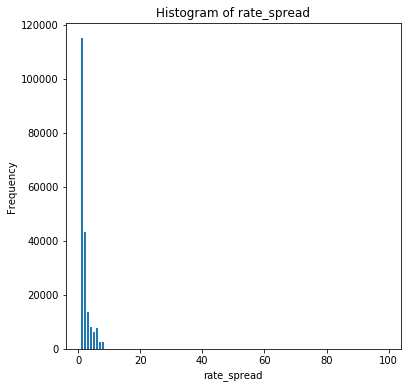

In [19]:

def plot_histogram(my_df, cols, bins = 200):
    for col in cols:
        fig = pyplot.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        my_df[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Frequency')# Set text for y axis
        pyplot.show()
        
num_cols = ['rate_spread']    
plot_histogram(train, num_cols)

QUESTION : compare avg "rate_spread" between 'applicant_ethnicity = 1' vs 'applicant_ethnicity = 3'

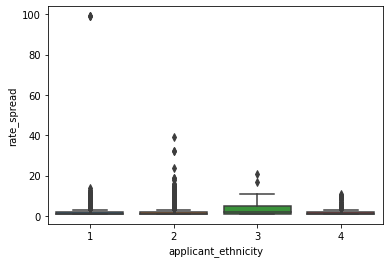

In [20]:
sns.boxplot(x='applicant_ethnicity',y='rate_spread',data=train)

In [21]:
train[train.applicant_ethnicity == 1.0].rate_spread.mean()

1.7496337995806646

In [22]:
train[train.applicant_ethnicity == 3.0].rate_spread.mean()

3.006747310193909

QUESTION : compare avg "rate_spread" between 'sex = 1' vs 'sex = 2'

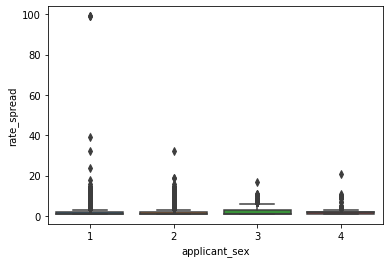

In [23]:
sns.boxplot(x='applicant_sex',y='rate_spread',data=train)

In [24]:
train[train.applicant_sex == 1.0].rate_spread.mean()

1.9647117176937416

In [25]:
train[train.applicant_sex == 2.0].rate_spread.mean()

1.976468831653602

Applicants where applicant_ethnicity=3 have a higher rate spread on average than where applicant_ethnicity=1.
Applicants where applicant_sex=1 have a lower rate spread on average than where applicant_sex=2. 

QUESTION: for applicants in state 43, get correlation between 'income' and 'loan amount'

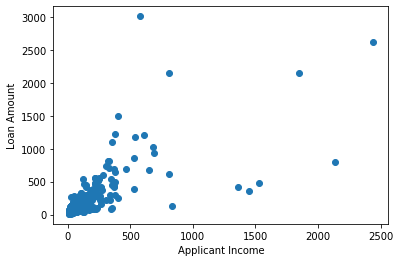

In [26]:
income = train[train.state_code == 43.0].applicant_income
loan = train[train.state_code == 43.0].loan_amount
pyplot.scatter(income,loan)
pyplot.xlabel('Applicant Income')
pyplot.ylabel('Loan Amount')
pyplot.show()

A higher applicant income is associated with a higher loan amount, on average. 

QUESTION: limiting just to state 48 and ignoring where county is missing (missing value being -1) analyze 'rate_spread' for different counties

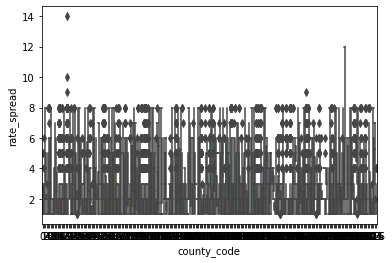

In [27]:
# get the 'rate_spread' and 'county_code' for 'state_code == 48
temp_df = train[train.state_code == 48.0][['county_code','rate_spread']]

# drop the rows where 'county_code' = -1.0
temp_df.drop(temp_df[temp_df.county_code == -1.0].index, inplace=True)

# do a boxplot
sns.boxplot(x='county_code',y='rate_spread',data=temp_df)

In state 48, the average rate spread across counties varies substantially, ranging from around 1% to around 7%.

QUESTION: Looking just at states 2 and 3 and just loan types 1, 2, and 3, compare avg rate spread between states


In [28]:
print(train.shape)
temp_df = train[((train.loan_type == 1.0) | (train.loan_type == 2.0) | (train.loan_type == 3.0))]
print(temp_df.shape)
temp_df2 = temp_df[(temp_df.state_code == 2.0) | (temp_df.state_code == 3.0)]
print(temp_df2.shape)

(200000, 23)
(198095, 23)
(9985, 23)


In [29]:
# calculate the average rate spread in state 2 vs the overall rate among states 2 and 3.
m1 = temp_df2[temp_df2.state_code == 2.0].rate_spread.mean()
print('Avg rate spread for state 2: %.2f' % m1)

m2 = temp_df2.rate_spread.mean()
print('Avg rate spread for states 2 and 3: %.2f'  %m2)


Avg rate spread for state 2: 2.77
Avg rate spread for states 2 and 3: 2.24


In [30]:
# calculate the average rate spread in state 3 vs the overall rate among states 2 and 3.
m1 = temp_df2[temp_df2.state_code == 3.0].rate_spread.mean()
print('Avg rate spread for state 3: %.2f' % m1)

m2 = temp_df2.rate_spread.mean()
print('Avg rate spread for states 2 and 3: %.2f'  %m2)

Avg rate spread for state 3: 1.72
Avg rate spread for states 2 and 3: 2.24


In [31]:
# calculate the average rate spread in state 2 vs the overall rate in state 3

m1 = temp_df2[temp_df2.state_code == 2.0].rate_spread.mean()
print('Avg rate spread for state 2: %.2f' % m1)

m2 = temp_df2[temp_df2.state_code == 3.0].rate_spread.mean()
print('Avg rate spread for state 3: %.2f'  %m2)

Avg rate spread for state 2: 2.77
Avg rate spread for state 3: 1.72


For loan types 1, 2, and 3, the average rate spread in state 2 is higher than for the corresponding loan type in state 3. 

### Remove outlier for dependent value

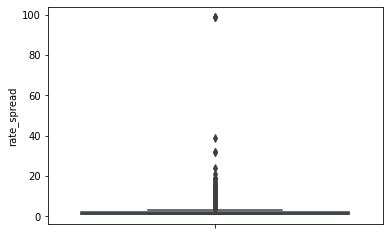

In [32]:
sns.boxplot(y='rate_spread',data=train)

In [33]:
# CUT OFF VALUE FOR TRAINING DATASET
cut_off = 50.0

In [34]:
train[(train['rate_spread']>cut_off)].count()

row_id                            3
loan_type                         3
property_type                     3
loan_purpose                      3
occupancy                         3
loan_amount                       3
preapproval                       3
msa_md                            3
state_code                        3
county_code                       3
applicant_ethnicity               3
applicant_race                    3
applicant_sex                     3
applicant_income                  3
population                        3
minority_population_pct           3
ffiecmedian_family_income         3
tract_to_msa_md_income_pct        3
number_of_owner-occupied_units    3
number_of_1_to_4_family_units     3
lender                            3
co_applicant                      3
rate_spread                       3
dtype: int64

In [35]:
train = train[train.rate_spread < cut_off]

In [36]:
train.shape

(199997, 23)

### Impute missing values for training dataset

In [37]:
# we are given the information that a value of '-1' indicates missing value for the following columns:
# msa_md, state_code, county_code
# if such a value exists, we will replace it with NaN
train['msa_md'].replace(-1.0, np.NaN,inplace=True)
train['state_code'].replace(-1.0, np.NaN,inplace=True)
train['county_code'].replace(-1.0, np.NaN,inplace=True)

In [38]:
train.isna().sum()

row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                         1338
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  10708
population                         1995
minority_population_pct            1995
ffiecmedian_family_income          1985
tract_to_msa_md_income_pct         2023
number_of_owner-occupied_units     2012
number_of_1_to_4_family_units      2016
lender                                0
co_applicant                          0
rate_spread                           0
dtype: int64

In [39]:
# let us see what percentage of the total data is missing
def missing_values_table(df):
        mis_val = df.isna().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [40]:
missing_values_table(train)

Your selected dataframe has 23 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
applicant_income,10708,5.4
tract_to_msa_md_income_pct,2023,1.0
number_of_1_to_4_family_units,2016,1.0
number_of_owner-occupied_units,2012,1.0
population,1995,1.0
minority_population_pct,1995,1.0
ffiecmedian_family_income,1985,1.0
state_code,1338,0.7


In [41]:
# if a feature is numeric, then use the mean()
# for categorical features, use mode()
train['state_code'].fillna(train['state_code'].mode()[0], inplace=True)
train['applicant_income'].fillna(train['applicant_income'].mean(), inplace=True)
train['population'].fillna(train['population'].mean(), inplace=True)
train['minority_population_pct'].fillna(train['minority_population_pct'].mean(), inplace=True)
train['ffiecmedian_family_income'].fillna(train['ffiecmedian_family_income'].mean(), inplace=True)
train['tract_to_msa_md_income_pct'].fillna(train['tract_to_msa_md_income_pct'].mean(), inplace=True)
train['number_of_owner-occupied_units'].fillna(train['number_of_owner-occupied_units'].mean(), inplace=True)
train['number_of_1_to_4_family_units'].fillna(train['number_of_1_to_4_family_units'].mean(), inplace=True)

In [42]:
# check for null values in the training dataset after imputing
train.isna().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
rate_spread                       0
dtype: int64

### Impute missing values for testing dataset

In [43]:
# we are given that a value of '-1' indicates missing value for the following columns:
# msa_md, state_code, county_code
# if such a value exists, we will replace it with NaN
test['msa_md'].replace(-1.0, np.NaN,inplace=True)
test['state_code'].replace(-1.0, np.NaN,inplace=True)
test['county_code'].replace(-1.0, np.NaN,inplace=True)

In [44]:
# check for null values in the test dataset
test.isna().sum()

row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                         1229
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  10371
population                         1918
minority_population_pct            1920
ffiecmedian_family_income          1905
tract_to_msa_md_income_pct         1946
number_of_owner-occupied_units     1933
number_of_1_to_4_family_units      1933
lender                                0
co_applicant                          0
dtype: int64

In [45]:
missing_values_table(test)

Your selected dataframe has 22 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
applicant_income,10371,5.2
tract_to_msa_md_income_pct,1946,1.0
number_of_owner-occupied_units,1933,1.0
number_of_1_to_4_family_units,1933,1.0
minority_population_pct,1920,1.0
population,1918,1.0
ffiecmedian_family_income,1905,1.0
state_code,1229,0.6


In [46]:
# we are given that a value of '-1' indicates missing value for the following columns:
# msa_md, state_code, county_code
# if such a value exists, we will replace it with NaN
test['state_code'].fillna(test['state_code'].mode()[0], inplace=True)
test['applicant_income'].fillna(test['applicant_income'].mean(), inplace=True)
test['population'].fillna(test['population'].mean(), inplace=True)
test['minority_population_pct'].fillna(test['minority_population_pct'].mean(), inplace=True)
test['ffiecmedian_family_income'].fillna(test['ffiecmedian_family_income'].mean(), inplace=True)
test['tract_to_msa_md_income_pct'].fillna(test['tract_to_msa_md_income_pct'].mean(), inplace=True)
test['number_of_owner-occupied_units'].fillna(test['number_of_owner-occupied_units'].mean(), inplace=True)
test['number_of_1_to_4_family_units'].fillna(test['number_of_1_to_4_family_units'].mean(), inplace=True)

In [47]:
# check for null values in the test dataset after imputing
test.isna().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
dtype: int64

### Exploratory Data Analysis

#### Statistics of the training dataset

In [48]:
# display statistics
train.describe()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,rate_spread
count,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,...,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000,199997.000000
mean,99999.276074,1.570944,1.154882,1.482612,1.061386,142.577004,2.702946,226.976180,28.530008,166.334515,...,73.618345,5391.100762,34.238297,64594.786796,89.283211,1402.878021,1927.345816,2001.307610,0.383511,1.977655
std,57734.831617,0.559410,0.365068,0.822160,0.246045,142.559560,0.545661,106.655451,15.490795,92.852504,...,102.829204,2655.697880,27.791187,12660.415790,14.982697,703.319155,882.100128,1271.143333,0.486242,1.613647
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,7.000000,0.326000,17860.000000,6.193000,3.000000,6.000000,0.000000,0.000000,1.000000
25%,50000.000000,1.000000,1.000000,1.000000,1.000000,67.000000,2.000000,154.000000,14.000000,83.000000,...,40.000000,3730.000000,11.047000,56763.000000,81.848000,936.000000,1348.000000,963.000000,0.000000,1.000000
50%,99999.000000,2.000000,1.000000,1.000000,1.000000,116.000000,3.000000,261.000000,30.000000,181.000000,...,59.000000,4986.000000,26.357000,63609.000000,98.619000,1311.000000,1808.000000,1834.000000,0.000000,1.000000
75%,149998.000000,2.000000,1.000000,2.000000,1.000000,179.000000,3.000000,318.000000,41.000000,249.000000,...,80.000000,6450.000000,51.640000,71175.000000,100.000000,1736.000000,2345.000000,3180.000000,1.000000,2.000000
max,199999.000000,4.000000,3.000000,3.000000,3.000000,11104.000000,3.000000,408.000000,52.000000,316.000000,...,10042.000000,34126.000000,100.000000,125095.000000,100.000000,8747.000000,13615.000000,4283.000000,1.000000,39.000000


The mean() values and minx/max ranges differ between features. We need to normalize these features.

In [49]:
print(train.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                        float64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                        int32
rate_spread                       float64
dtype: object


#### Histograms of numeric features

In [50]:

def plot_histogram_with_overlay(the_array, x_title, the_flag):
    
    pyplot.hist(the_array, alpha=0.5, bins=50, density=True)

    if(the_flag==True):
        # find minimum and maximum of xticks, so we know
        # where we should compute theoretical distribution
        xt = pyplot.xticks()[0]  
        xmin, xmax = min(xt), max(xt)  
        lnspc = np.linspace(xmin, xmax, len(the_array))

        m, s = stats.norm.fit(the_array) # get mean and standard deviation  
        pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
        # Plot some fancy text to show us what the parameters of the distribution are (mean and standard deviation)
        pyplot.text(x=np.min(the_array), y=0.1, s=r"$\mu=%0.1f$" % m + "\n" + r"$\sigma=%0.1f$" % s, color='r')
        pyplot.plot(lnspc, pdf_g, label="Normal") # plot it

    # Standard plot stuff
    pyplot.xlabel(x_title)
    pyplot.title('Histogram of ' + x_title )
    pyplot.show()
        

In [51]:
pyplot.rcParams["figure.figsize"]=5,5

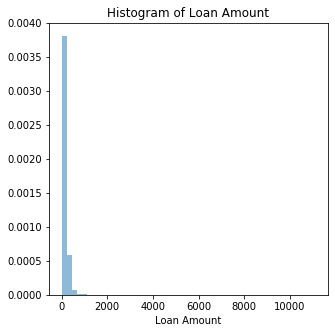

In [52]:
plot_histogram_with_overlay(train['loan_amount'], "Loan Amount",False)

Significant right skew is observed for the loan_amount.

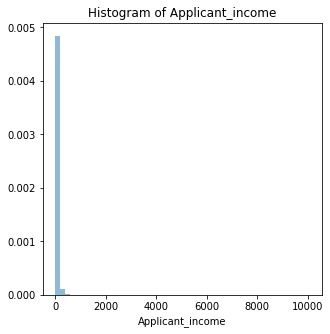

In [53]:
plot_histogram_with_overlay(train['applicant_income'], "Applicant_income", False)

Significant right skew is observed for the applicant_income.

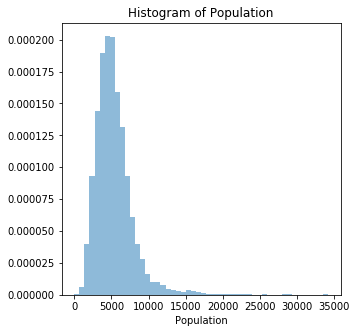

In [54]:
plot_histogram_with_overlay(train['population'], "Population",False)

Significant right skew is observed for the population.

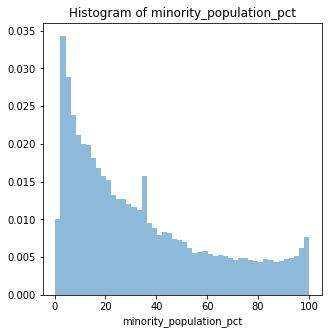

In [55]:
plot_histogram_with_overlay(train['minority_population_pct'], "minority_population_pct",False)

The histogram for minotrity_population_pct seems to be exponential.

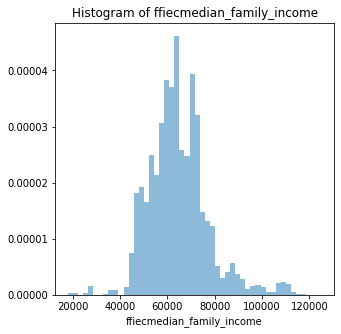

In [56]:
plot_histogram_with_overlay(train['ffiecmedian_family_income'], "ffiecmedian_family_income",False)

Some small right skew is observed for ffiecmedian_family_income.

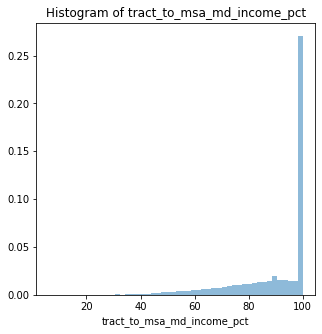

In [57]:
plot_histogram_with_overlay(train['tract_to_msa_md_income_pct'], "tract_to_msa_md_income_pct",False)

Significant left skew is observed for tract_to_msa_md_income_pct.

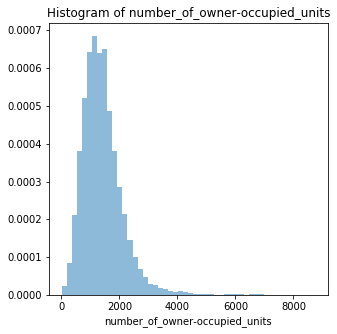

In [58]:
plot_histogram_with_overlay(train['number_of_owner-occupied_units'], "number_of_owner-occupied_units",False)

Some small right skew is observed for number_of_owner-occupied_units.

#### Categorical features

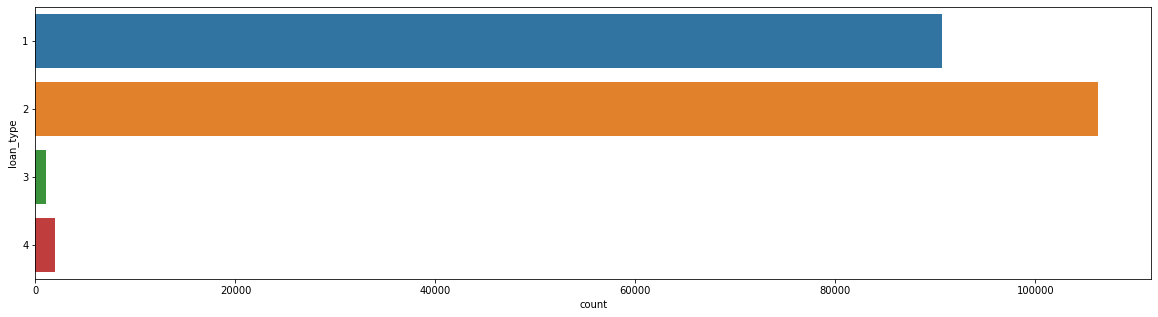

In [59]:
# Checking the frequency distribution of 'loan type' 
# 1 -- Conventional (any loan other than FHA, VA, FSA, or RHS loans)
# 2 -- FHA-insured (Federal Housing Administration)
# 3 -- VA-guaranteed (Veterans Administration)
# 4 -- FSA/RHS (Farm Service Agency or Rural Housing Service)

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="loan_type", data=train);

It seems that most of the loans are "FHA-insured".

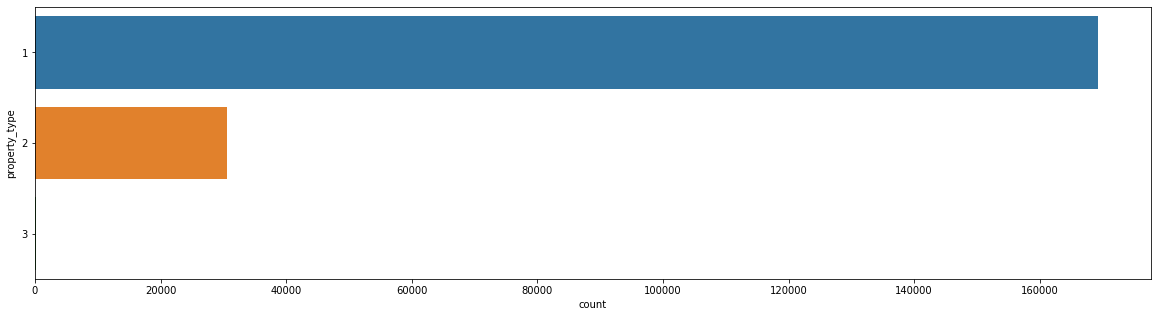

In [60]:
# Checking the frequency distribution of 'property type' 
# 1 -- One to four-family (other than manufactured housing)
# 2 -- Manufactured housing
# 3 -- Multifamily

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="property_type", data=train);

It seems that '1-4 family' homes are most financed. Also there are no multifamily entries in the training dataset. 

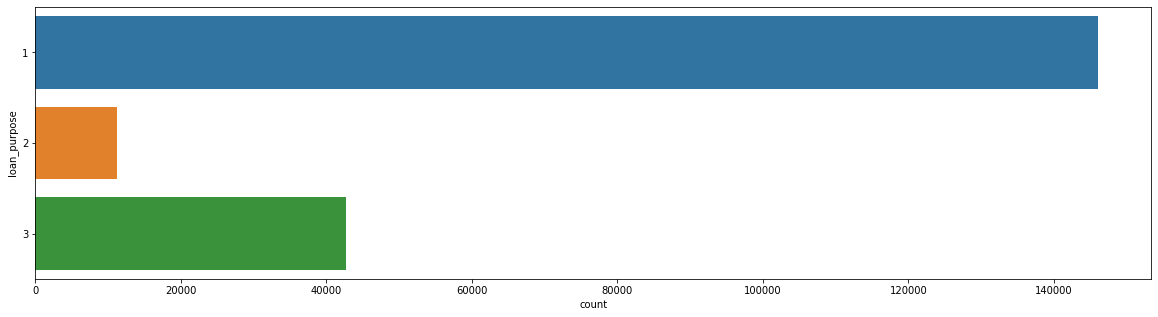

In [61]:
# Checking the frequency distribution of 'loan purpose' 
# 1 -- Home purchase
# 2 -- Home improvement
# 3 -- Refinancing

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="loan_purpose", data=train);

Most loans are for home purchase.

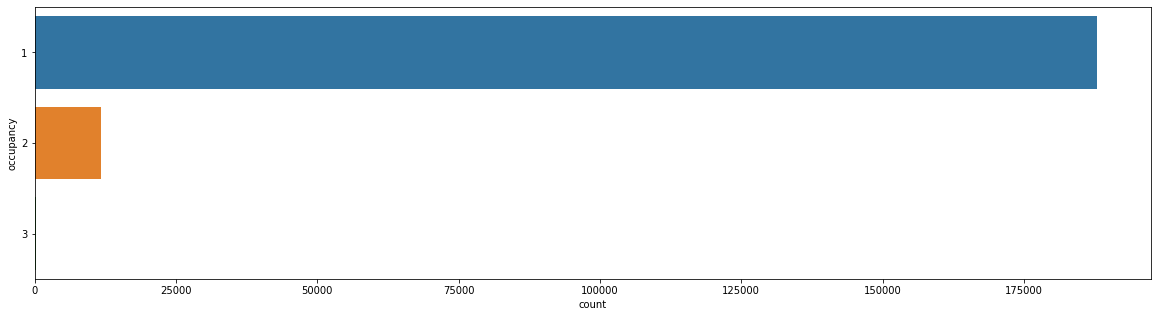

In [62]:
# Checking the frequency distribution of 'occupancy' 
# 1 -- Owner-occupied as a principal dwelling
# 2 -- Not owner-occupied
# 3 -- Not applicable

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="occupancy", data=train);

Most loans are for principle dwelling.

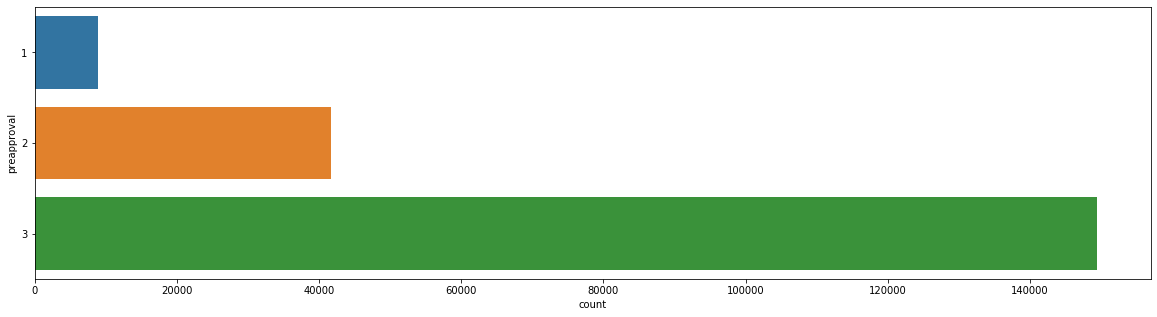

In [63]:
# Checking the frequency distribution of 'preapproval'  requirement
# 1 -- Preapproval was requested
# 2 -- Preapproval was not requested
# 3 -- Not applicable

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="preapproval", data=train);

Preapproval was not required for most cases.

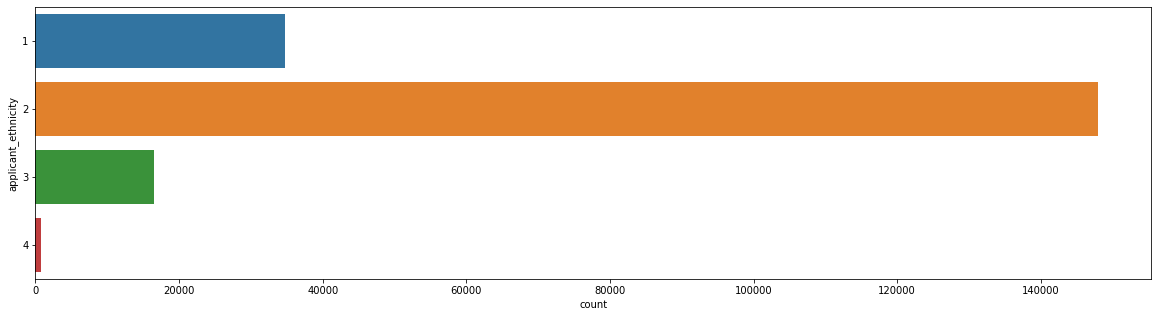

In [64]:
# Checking the frequency distribution of 'applicant ethnicity'
# 1 -- Hispanic or Latino
# 2 -- Not Hispanic or Latino
# 3 -- Information not provided by applicant in mail, Internet, or telephone pplication
# 4 -- Not applicable
# 5 -- No co-applicant

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="applicant_ethnicity", data=train);

Mortgages were rewarded to mostly "no hispanic or latino"

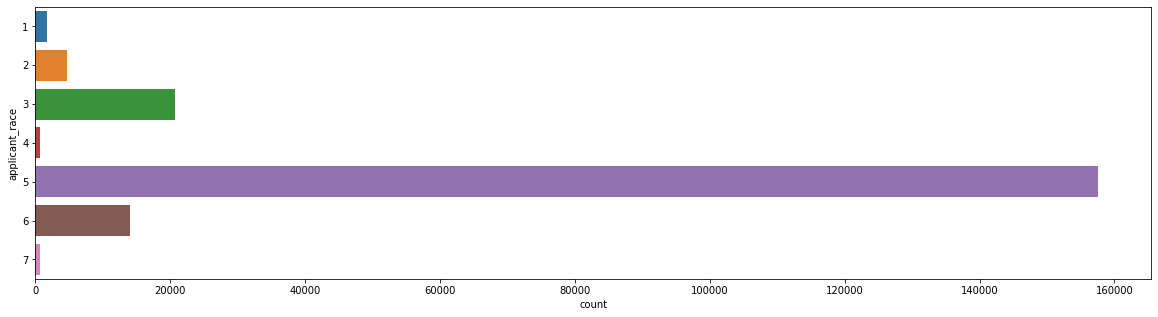

In [65]:
# Checking the frequency distribution of 'applicant race'
# 1 -- American Indian or Alaska Native
# 2 -- Asian
# 3 -- Black or African American
# 4 -- Native Hawaiian or Other Pacific Islander
# 5 -- White
# 6 -- Information not provided by applicant in mail, Internet, or telephone application
# 7 -- Not applicable
# 8 -- No co-applicant

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="applicant_race", data=train);

Loan approvals were overwhelmingly granted to whites.

There are no rows where applicant_race = 8.0

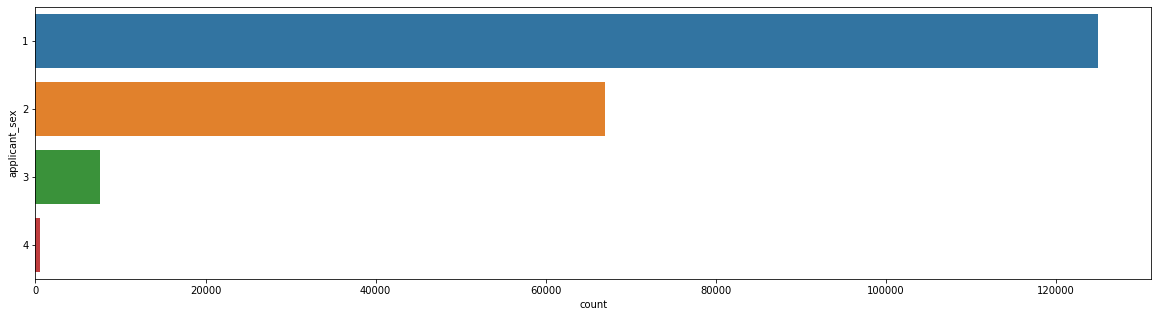

In [66]:
# Checking the frequency distribution of 'applicant sex'
# 1 -- Male
# 2 -- Female
# 3 -- Information not provided by applicant in mail, Internet, or telephone application
# 4 or 5 -- Not applicable

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="applicant_sex", data=train);

Most loans were granted to males. There are no rows where applicant_sex = 5.0.

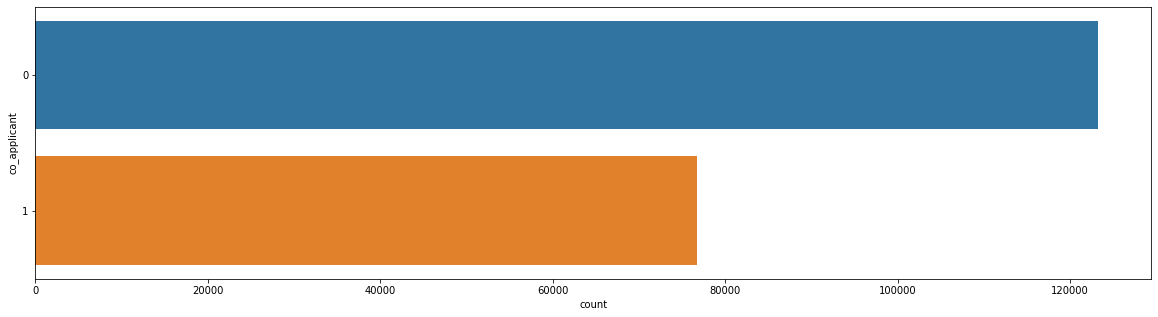

In [67]:
# Checking the frequency distribution of 'co applicant'
# 0 -- no spouse
# 1 -- spouse

# Let's view the distribution
pyplot.figure(figsize=(20, 5)) 
sns.countplot(y="co_applicant", data=train);

Almost twice as many mortgages are granted to no-spouse applicants.

#### Relationships between the categorical features and the dependent variable

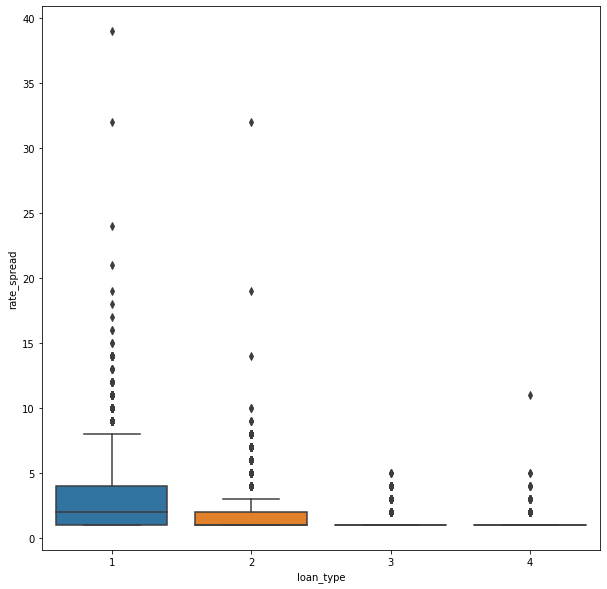

In [68]:
# Checking the frequency distribution of 'loan type' 
# 1 -- Conventional (any loan other than FHA, VA, FSA, or RHS loans)
# 2 -- FHA-insured (Federal Housing Administration)
# 3 -- VA-guaranteed (Veterans Administration)
# 4 -- FSA/RHS (Farm Service Agency or Rural Housing Service)

pyplot.figure(figsize=(10, 10)) 
sns.boxplot('loan_type','rate_spread',data=train)

The average rate spread is higher for conventional loans.

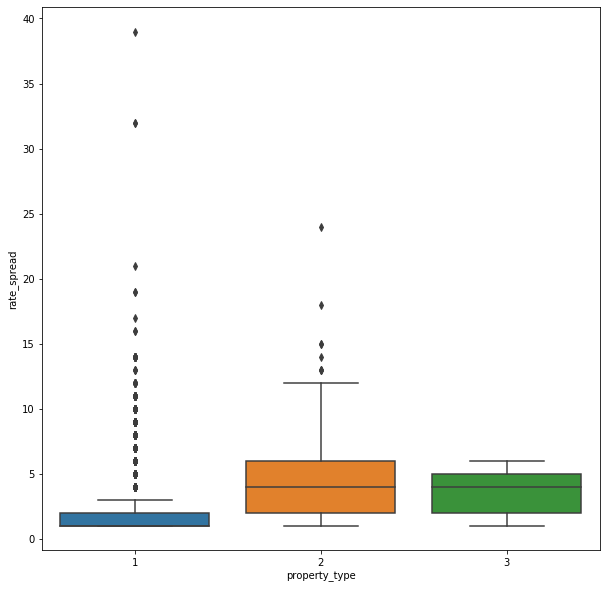

In [69]:
# Checking the frequency distribution of 'property type' 
# 1 -- One to four-family (other than manufactured housing)
# 2 -- Manufactured housing
# 3 -- Multifamily

pyplot.figure(figsize=(10,10)) 
sns.boxplot('property_type','rate_spread',data=train)

One-to-four family loans have the lowest average rate_spread

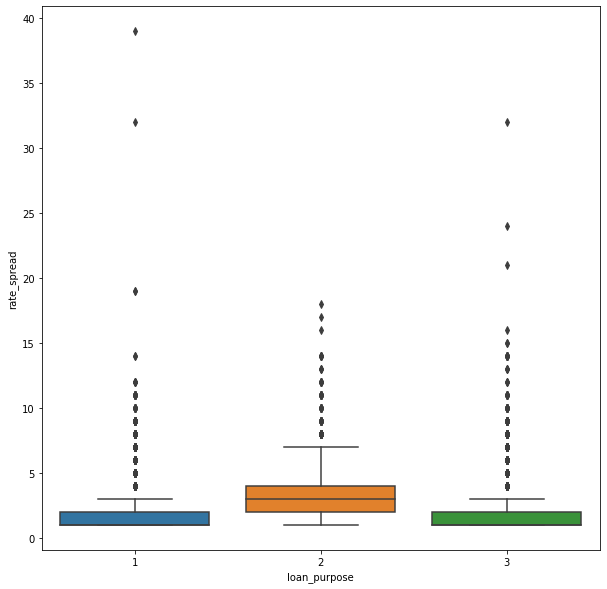

In [70]:
# Checking the frequency distribution of 'loan purpose' 
# 1 -- Home purchase
# 2 -- Home improvement
# 3 -- Refinancing

pyplot.figure(figsize=(10,10)) 
sns.boxplot('loan_purpose','rate_spread',data=train)

Home reimprovement loans have a higher average rate spread.

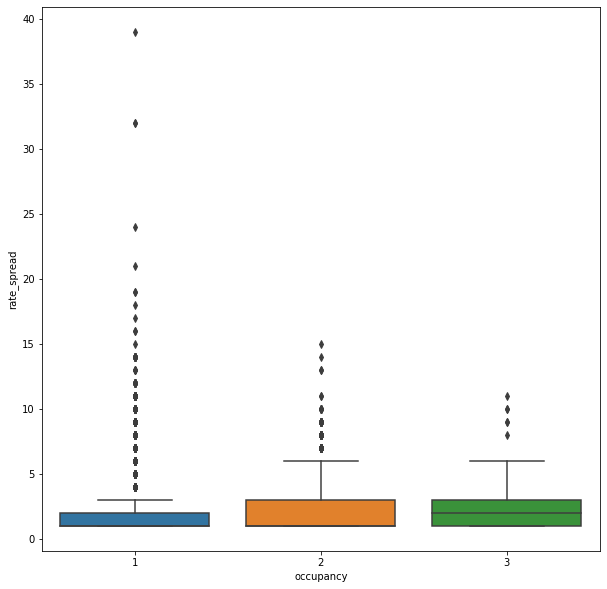

In [71]:
# Checking the frequency distribution of 'occupancy' 
# 1 -- Owner-occupied as a principal dwelling
# 2 -- Not owner-occupied
# 3 -- Not applicable

pyplot.figure(figsize=(10,10)) 
sns.boxplot('occupancy','rate_spread',data=train)

Unknown or "not applicable" occupancy has the highest average loan spread

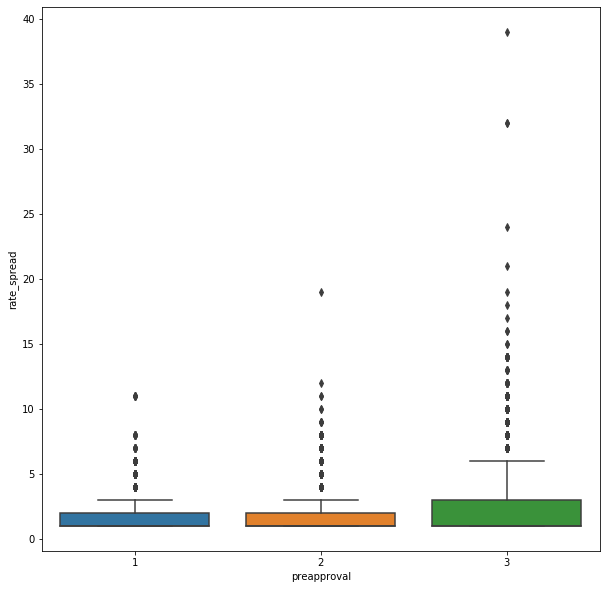

In [72]:
# Checking the frequency distribution of 'preapproval'  requirement
# 1 -- Preapproval was requested
# 2 -- Preapproval was not requested
# 3 -- Not applicable

pyplot.figure(figsize=(10,10)) 
sns.boxplot('preapproval','rate_spread',data=train)

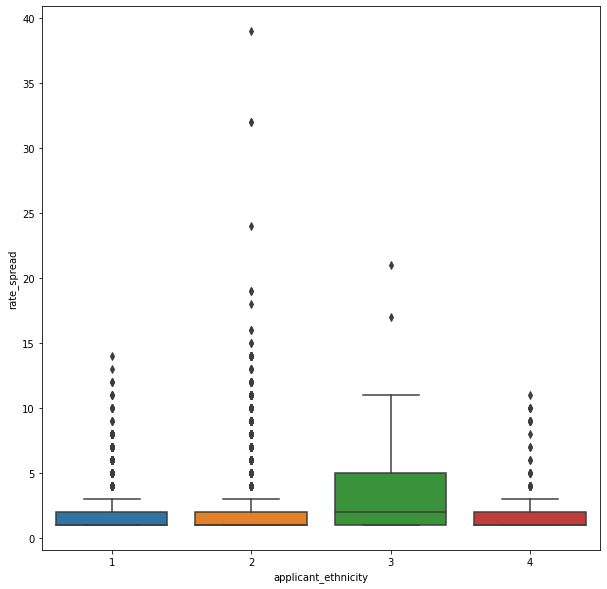

In [73]:
# Checking the frequency distribution of 'applicant ethnicity'
# 1 -- Hispanic or Latino
# 2 -- Not Hispanic or Latino
# 3 -- Information not provided by applicant in mail, Internet, or telephone pplication
# 4 -- Not applicable
# 5 -- No co-applicant

pyplot.figure(figsize=(10,10)) 
sns.boxplot('applicant_ethnicity','rate_spread',data=train)

If ethnicity information is not provided by the applicant, the average rate spread is much higher. THIS IS VERY ALARMING.

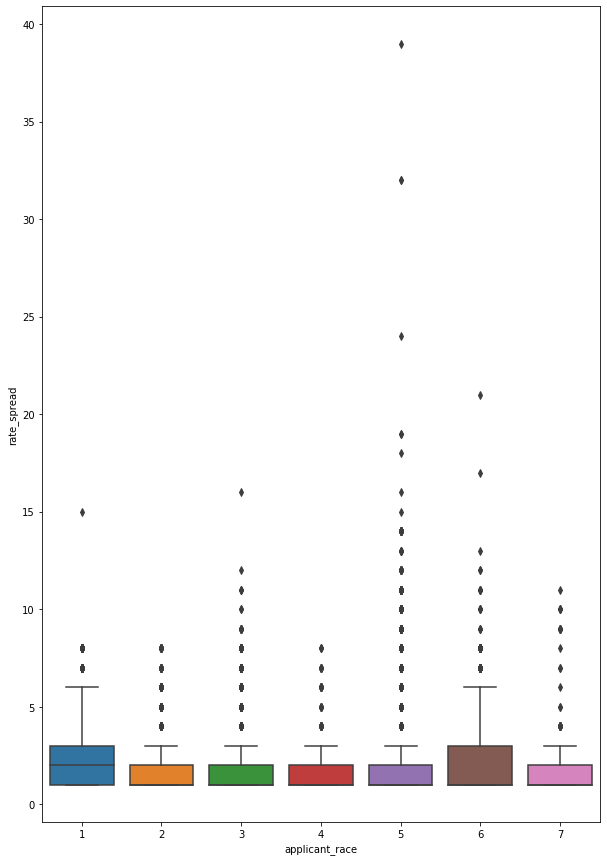

In [74]:
# Checking the frequency distribution of 'applicant race'
# 1 -- American Indian or Alaska Native
# 2 -- Asian
# 3 -- Black or African American
# 4 -- Native Hawaiian or Other Pacific Islander
# 5 -- White
# 6 -- Information not provided by applicant in mail, Internet, or telephone application
# 7 -- Not applicable
# 8 -- No co-applicant

pyplot.figure(figsize=(10,15)) 
sns.boxplot('applicant_race','rate_spread',data=train)

Average rate spread is much higher for "American Indian or Alaska Natives". Similar to ethnicity, if race information is not provided by the applicant, the standard deviation for rate spread is much greater than others.

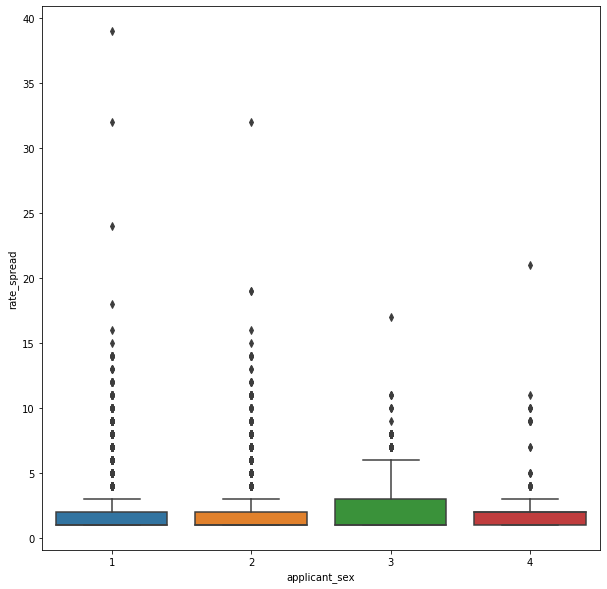

In [75]:
# Checking the frequency distribution of 'applicant sex'
# 1 -- Male
# 2 -- Female
# 3 -- Information not provided by applicant in mail, Internet, or telephone application
# 4 or 5 -- Not applicable

pyplot.figure(figsize=(10,10)) 
sns.boxplot('applicant_sex','rate_spread',data=train)

While the average rate spread is pretty much equal, if the applicant does not specify gender, then the standard deviation of rate spread is higher. 

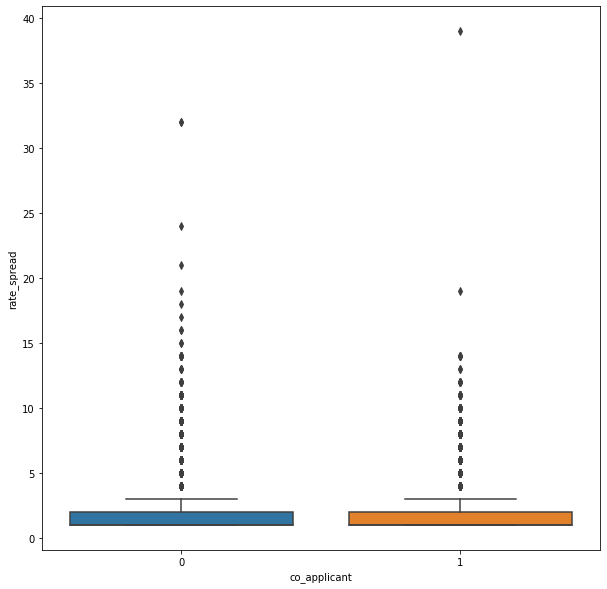

In [76]:
# Checking the frequency distribution of 'co applicant'
# 0 -- no spouse
# 1 -- spouse

pyplot.figure(figsize=(10,10)) 
sns.boxplot('co_applicant','rate_spread',data=train)

There is not much difference in resulting rate spread for different co applicant types. 

### Transforming  the training dataset

In [77]:
print(train.dtypes)

row_id                              int64
loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                        float64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                        int32
rate_spread                       float64
dtype: object


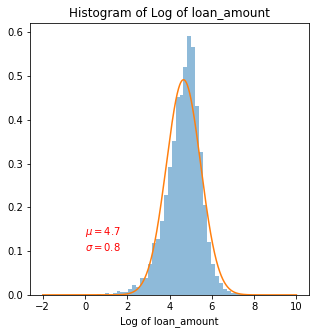

In [78]:
# we will apply log transformation to 'loan_amount' since its histogram had skew
# we are adding a new feature
train['log_of_loan_amount'] = np.log(train['loan_amount'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_loan_amount'], "Log of loan_amount", True)

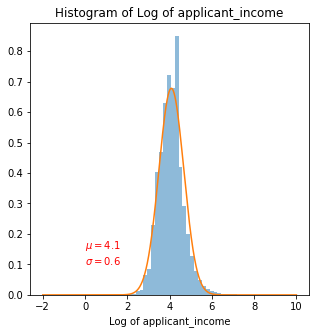

In [79]:
# we will apply log transformation to 'applicant_income' since its histogram had skew
# we are adding a new feature
train['log_of_applicant_income'] = np.log(train['applicant_income'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_applicant_income'], "Log of applicant_income",True)

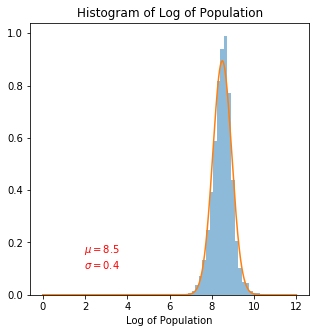

In [80]:
# we will apply log transformation to 'population' since its histogram had skew
# we are adding a new feature
train['log_of_population'] = np.log(train['population'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_population'], "Log of Population",True)

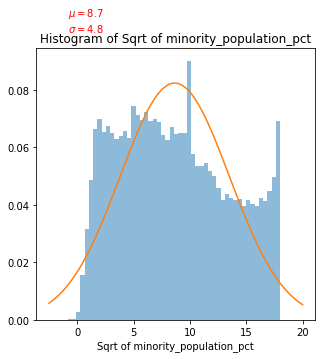

In [81]:
from scipy.stats import boxcox
# we will apply square root transformation to 'minority_population_pct' 
# since its histogram had a decaying exponential skew
# we are adding a new feature
train['sqrt_of_minority_population_pct'] = boxcox(train['minority_population_pct'],0.5)
# check the histogram after log transformation
plot_histogram_with_overlay(train['sqrt_of_minority_population_pct'], "Sqrt of minority_population_pct",True)

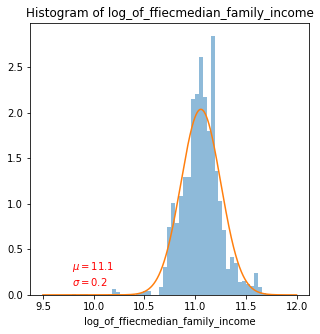

In [82]:
# we will apply log transformation to 'ffiecmedian_family_income' since its histogram had skew
# we are adding a new feature
train['log_of_ffiecmedian_family_income'] = np.log(train['ffiecmedian_family_income'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_ffiecmedian_family_income'], "log_of_ffiecmedian_family_income",True)

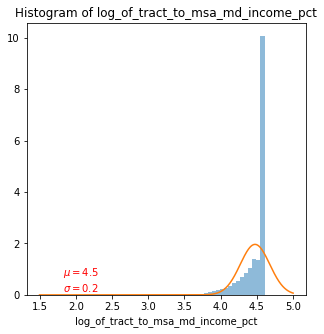

In [83]:
# we will apply log transformation to 'tract_to_msa_md_income_pct' since its histogram had skew
# we are adding a new feature
train['log_of_tract_to_msa_md_income_pct'] = np.log(train['tract_to_msa_md_income_pct'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_tract_to_msa_md_income_pct'], "log_of_tract_to_msa_md_income_pct",True)

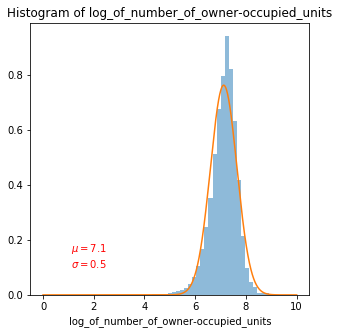

In [84]:
# we will apply log transformation to 'number_of_owner-occupied_units' since its histogram had skew
# we are adding a new feature
train['log_of_number_of_owner-occupied_units'] = np.log(train['number_of_owner-occupied_units'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_number_of_owner-occupied_units'], "log_of_number_of_owner-occupied_units",True)

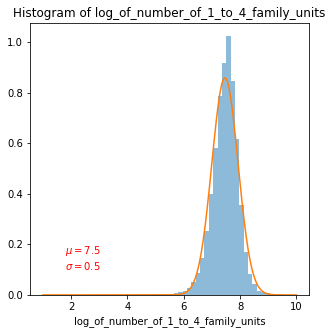

In [85]:
# we will apply log transformation to 'number_of_1_to_4_family_units' since its histogram had skew
# we are adding a new feature
train['log_of_number_of_1_to_4_family_units'] = np.log(train['number_of_1_to_4_family_units'])
# check the histogram after log transformation
plot_histogram_with_overlay(train['log_of_number_of_1_to_4_family_units'], "log_of_number_of_1_to_4_family_units",True)

### Binning the training dataset

In [86]:
# binning msa_md
def bin_msa_md(x):
    if 49 >= x >= 0: return 0
    elif 99 >= x >= 50: return 1
    elif 149 >= x >= 100: return 2
    elif 199 >= x >= 150: return 3
    elif 249 >= x >= 200: return 4
    elif 299 >= x >= 250: return 5
    elif 349 >= x >= 300: return 6
    elif 399 >= x >= 350: return 7
    elif 449 >= x >= 400: return 8
    else : return 9

In [87]:
train['msa_md_group'] = train['msa_md'].map(bin_msa_md)

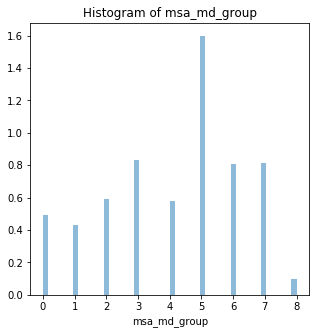

In [88]:
plot_histogram_with_overlay(train['msa_md_group'], "msa_md_group",False)

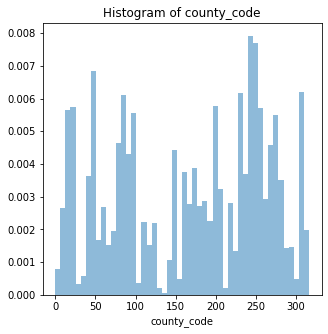

In [89]:
plot_histogram_with_overlay(train['county_code'], "county_code",False)

In [90]:
# binning county_code

def bin_county_code(x):
    if 49 >= x >= 0: return 0
    elif 99 >= x >= 50: return 1
    elif 149 >= x >= 100: return 2
    elif 199 >= x >= 150: return 3
    elif 249 >= x >= 200: return 4
    elif 299 >= x >= 250: return 5
    elif 349 >= x >= 300: return 6
    elif 399 >= x >= 350: return 7
    elif 449 >= x >= 400: return 8
    else : return 9

In [91]:
train['county_group'] = train['county_code'].map(bin_county_code)

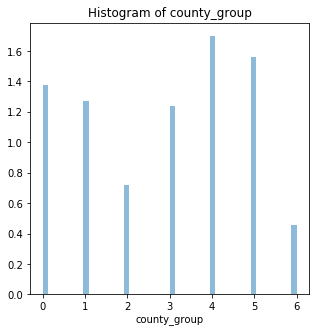

In [92]:
plot_histogram_with_overlay(train['county_group'], "county_group",False)

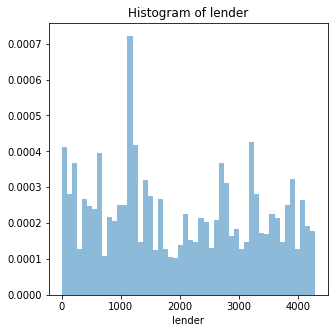

In [93]:
plot_histogram_with_overlay(train['lender'], "lender",False)

In [94]:
# binning lender

def bin_lender(x):
    if 499 >= x >= 0: return 0
    elif 999 >= x >= 500: return 1
    elif 1499 >= x >= 1000: return 2
    elif 1999 >= x >= 1500: return 3
    elif 2499 >= x >= 2000: return 4
    elif 2999 >= x >= 2500: return 5
    elif 3499 >= x >= 3000: return 6
    elif 3999 >= x >= 3500: return 7
    elif 4499 >= x >= 4000: return 8
    else : return 9

In [95]:
train['lender_group'] = train['lender'].map(bin_lender)

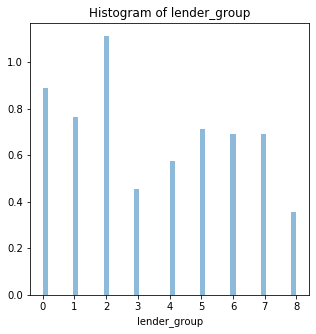

In [96]:
plot_histogram_with_overlay(train['lender_group'], "lender_group",False)

### Setting the data types for categorical features of the training dataset

In [97]:
# check the resulting data types for training dataset
print(train.dtypes)

row_id                                     int64
loan_type                                  int64
property_type                              int64
loan_purpose                               int64
occupancy                                  int64
loan_amount                              float64
preapproval                                int64
msa_md                                     int64
state_code                               float64
county_code                                int64
applicant_ethnicity                        int64
applicant_race                             int64
applicant_sex                              int64
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

In [98]:
# check the resulting data types for training dataset
print(train.dtypes)

row_id                                     int64
loan_type                                  int64
property_type                              int64
loan_purpose                               int64
occupancy                                  int64
loan_amount                              float64
preapproval                                int64
msa_md                                     int64
state_code                               float64
county_code                                int64
applicant_ethnicity                        int64
applicant_race                             int64
applicant_sex                              int64
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

### Transforming the test dataset

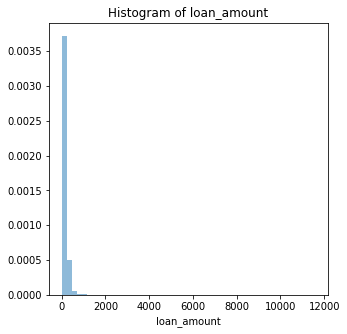

In [99]:
plot_histogram_with_overlay(test['loan_amount'], "loan_amount",False)

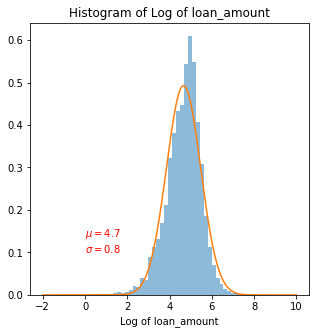

In [100]:
test['log_of_loan_amount'] = np.log(test['loan_amount'])
plot_histogram_with_overlay(test['log_of_loan_amount'], "Log of loan_amount",True)

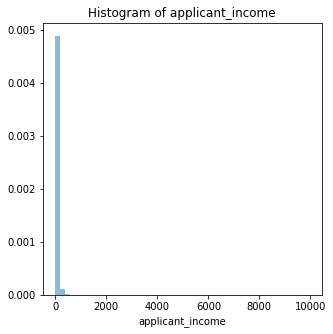

In [101]:
plot_histogram_with_overlay(test['applicant_income'], "applicant_income",False)

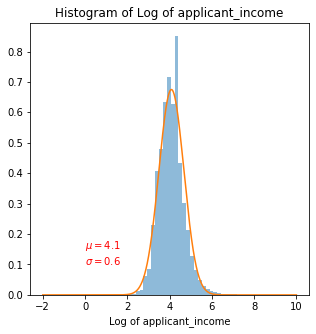

In [102]:
test['log_of_applicant_income'] = np.log(test['applicant_income'])
plot_histogram_with_overlay(test['log_of_applicant_income'], "Log of applicant_income",True)

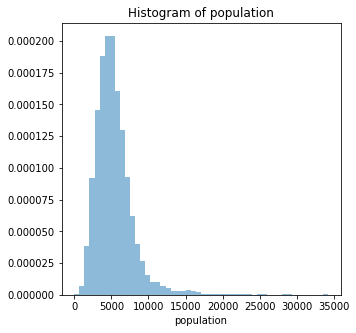

In [103]:
plot_histogram_with_overlay(test['population'], "population",False)

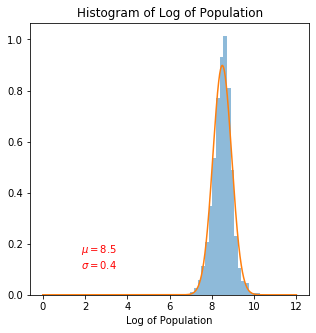

In [104]:
test['log_of_population'] = np.log(test['population'])
plot_histogram_with_overlay(test['log_of_population'], "Log of Population",True)

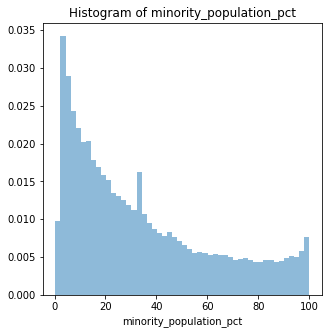

In [105]:
plot_histogram_with_overlay(test['minority_population_pct'], "minority_population_pct",False)

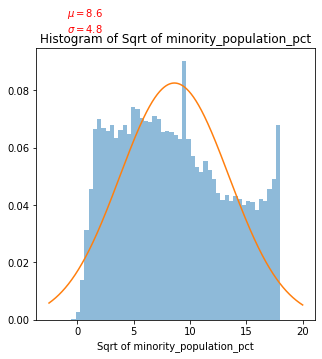

In [106]:
from scipy.stats import boxcox
test['sqrt_of_minority_population_pct'] = boxcox(test['minority_population_pct'],0.5)
plot_histogram_with_overlay(test['sqrt_of_minority_population_pct'], "Sqrt of minority_population_pct",True)

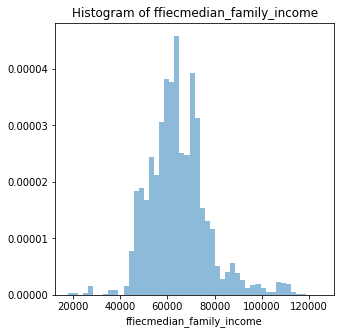

In [107]:
plot_histogram_with_overlay(test['ffiecmedian_family_income'], "ffiecmedian_family_income",False)

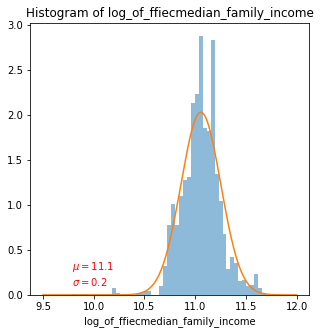

In [108]:
test['log_of_ffiecmedian_family_income'] = np.log(test['ffiecmedian_family_income'])
plot_histogram_with_overlay(test['log_of_ffiecmedian_family_income'], "log_of_ffiecmedian_family_income",True)

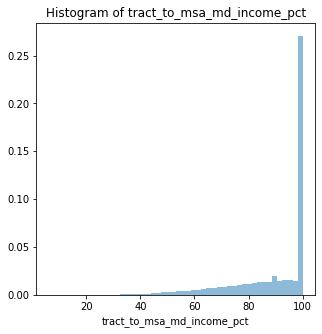

In [109]:
plot_histogram_with_overlay(test['tract_to_msa_md_income_pct'], "tract_to_msa_md_income_pct",False)

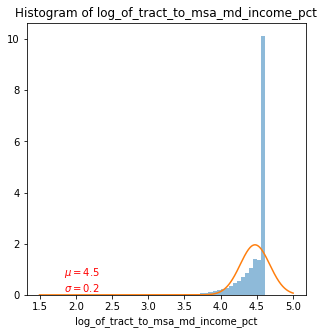

In [110]:
test['log_of_tract_to_msa_md_income_pct'] = np.log(test['tract_to_msa_md_income_pct'])
plot_histogram_with_overlay(test['log_of_tract_to_msa_md_income_pct'], "log_of_tract_to_msa_md_income_pct",True)

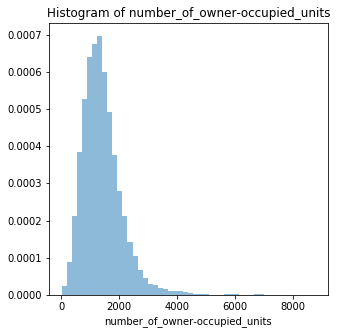

In [111]:
plot_histogram_with_overlay(test['number_of_owner-occupied_units'], "number_of_owner-occupied_units",False)

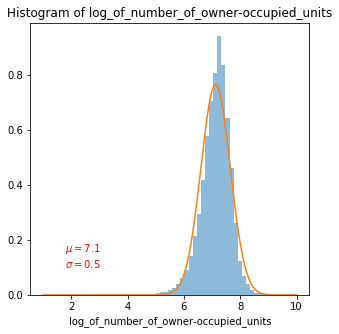

In [112]:
test['log_of_number_of_owner-occupied_units'] = np.log(test['number_of_owner-occupied_units'])
plot_histogram_with_overlay(test['log_of_number_of_owner-occupied_units'], "log_of_number_of_owner-occupied_units",True)

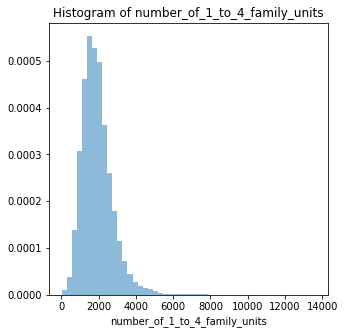

In [113]:
plot_histogram_with_overlay(train['number_of_1_to_4_family_units'], "number_of_1_to_4_family_units",False)

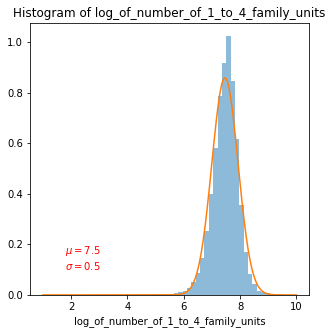

In [114]:
test['log_of_number_of_1_to_4_family_units'] = np.log(test['number_of_1_to_4_family_units'])
plot_histogram_with_overlay(train['log_of_number_of_1_to_4_family_units'], "log_of_number_of_1_to_4_family_units",True)

### Binning the test dataset

In [115]:
test['msa_md_group'] = test['msa_md'].map(bin_msa_md)
test['county_group'] = test['county_code'].map(bin_county_code)
test['lender_group'] = test['lender'].map(bin_lender)

### Display correlation matrix

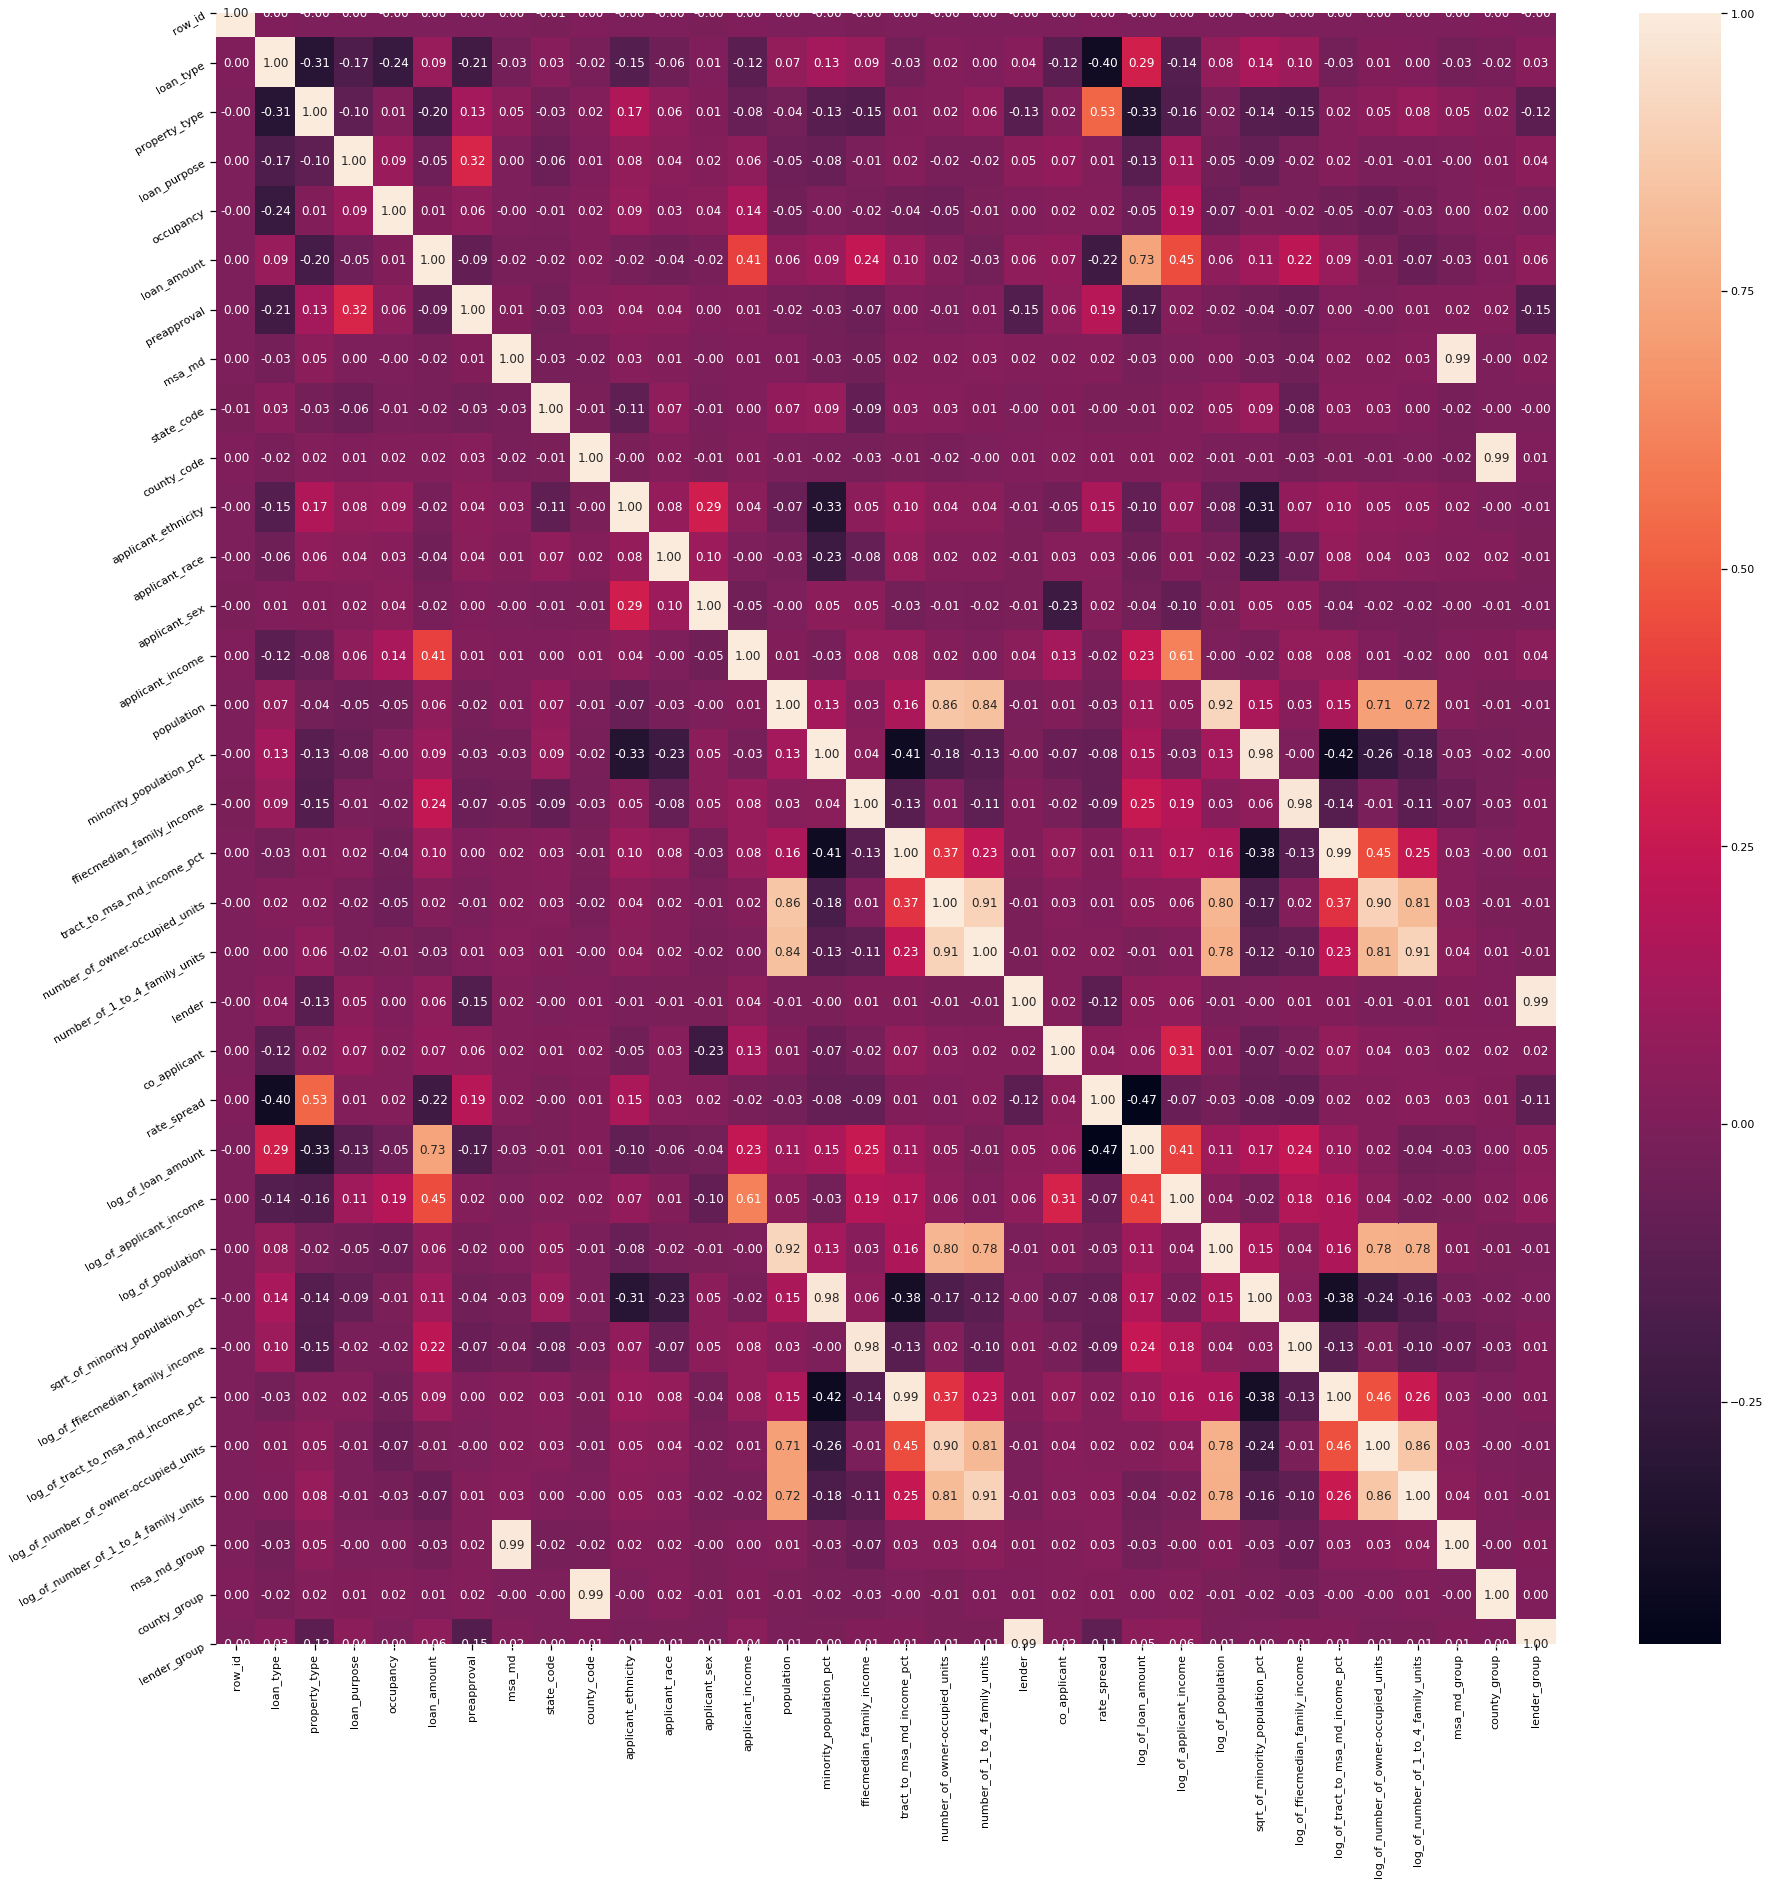

In [116]:
pyplot.rcParams["figure.figsize"]=30,30

corr = train.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
# pyplot.figure(figsize=(15,8))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)
pyplot.savefig('corr.png')

### Setting the data types for categorical features of the training and test datasets for the Cat Boost Algorithm

In [117]:
# check the resulting data types for training dataset
print(train.dtypes)

row_id                                     int64
loan_type                                  int64
property_type                              int64
loan_purpose                               int64
occupancy                                  int64
loan_amount                              float64
preapproval                                int64
msa_md                                     int64
state_code                               float64
county_code                                int64
applicant_ethnicity                        int64
applicant_race                             int64
applicant_sex                              int64
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

In [118]:
train = train.astype({"loan_type": str, 
                    "property_type": str,
                    "loan_purpose": str,
                    "occupancy": str,
                    "preapproval": str,
                    "msa_md": str,
                    "state_code": str,
                    "county_code": str,
                    "applicant_ethnicity": str,
                    "applicant_race": str,
                    "applicant_sex": str,
                    "lender": str,
                    "co_applicant": str,
                    "msa_md_group" : str,
                    "county_group" : str,
                    "lender_group" : str
                   })

In [119]:
# check the resulting data types for training dataset
print(train.dtypes)

row_id                                     int64
loan_type                                 object
property_type                             object
loan_purpose                              object
occupancy                                 object
loan_amount                              float64
preapproval                               object
msa_md                                    object
state_code                                object
county_code                               object
applicant_ethnicity                       object
applicant_race                            object
applicant_sex                             object
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

In [120]:
# check the resulting data types for test dataset
print(test.dtypes)

row_id                                     int64
loan_type                                  int64
property_type                              int64
loan_purpose                               int64
occupancy                                  int64
loan_amount                              float64
preapproval                                int64
msa_md                                     int64
state_code                               float64
county_code                                int64
applicant_ethnicity                        int64
applicant_race                             int64
applicant_sex                              int64
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

In [121]:
test = test.astype({"loan_type": str, 
                    "property_type": str,
                    "loan_purpose": str,
                    "occupancy": str,
                    "preapproval": str,
                    "msa_md": str,
                    "state_code": str,
                    "county_code": str,
                    "applicant_ethnicity": str,
                    "applicant_race": str,
                    "applicant_sex": str,
                    "lender": str,
                    "co_applicant": str,
                    "msa_md_group" : str,
                    "county_group" : str,
                    "lender_group" : str
                   })

In [122]:
# check the resulting data types for test dataset
print(test.dtypes)

row_id                                     int64
loan_type                                 object
property_type                             object
loan_purpose                              object
occupancy                                 object
loan_amount                              float64
preapproval                               object
msa_md                                    object
state_code                                object
county_code                               object
applicant_ethnicity                       object
applicant_race                            object
applicant_sex                             object
applicant_income                         float64
population                               float64
minority_population_pct                  float64
ffiecmedian_family_income                float64
tract_to_msa_md_income_pct               float64
number_of_owner-occupied_units           float64
number_of_1_to_4_family_units            float64
lender              

### Create the features matrix and target array

In [123]:
#Creating a training set for modeling and validation set to check model performance
X_train = train.drop(['row_id','loan_amount','applicant_income','population','minority_population_pct',
                      'ffiecmedian_family_income','tract_to_msa_md_income_pct',
                      'number_of_owner-occupied_units','number_of_1_to_4_family_units',
#                     'msa_md',
#                      'msa_md_group'
#                    'county_code',
#                      'country_group'
#                      'lender',
#                      'lender_group'
                      'rate_spread'], axis=1)
y_train = train.rate_spread

X_test = test.drop(['row_id','loan_amount','applicant_income','population','minority_population_pct',
                      'ffiecmedian_family_income','tract_to_msa_md_income_pct',
                      'number_of_owner-occupied_units','number_of_1_to_4_family_units',
#                     'msa_md',
#                      'msa_md_group'
#                    'county_code',
#                      'country_group'
#                      'lender',
#                      'lender_group'
#                     'lender'
                   ], axis=1)

In [124]:
X_train.dtypes

loan_type                                 object
property_type                             object
loan_purpose                              object
occupancy                                 object
preapproval                               object
msa_md                                    object
state_code                                object
county_code                               object
applicant_ethnicity                       object
applicant_race                            object
applicant_sex                             object
lender                                    object
co_applicant                              object
log_of_loan_amount                       float64
log_of_applicant_income                  float64
log_of_population                        float64
sqrt_of_minority_population_pct          float64
log_of_ffiecmedian_family_income         float64
log_of_tract_to_msa_md_income_pct        float64
log_of_number_of_owner-occupied_units    float64
log_of_number_of_1_t

In [125]:
X_test.dtypes

loan_type                                 object
property_type                             object
loan_purpose                              object
occupancy                                 object
preapproval                               object
msa_md                                    object
state_code                                object
county_code                               object
applicant_ethnicity                       object
applicant_race                            object
applicant_sex                             object
lender                                    object
co_applicant                              object
log_of_loan_amount                       float64
log_of_applicant_income                  float64
log_of_population                        float64
sqrt_of_minority_population_pct          float64
log_of_ffiecmedian_family_income         float64
log_of_tract_to_msa_md_income_pct        float64
log_of_number_of_owner-occupied_units    float64
log_of_number_of_1_t

### Model scoring using Cross Validation

In [126]:
num_folds = 3
seed = 1234
scoring_metric = 'r2'

In [127]:
# this is needed for the Cat Boost model
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
print(categorical_features_indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 21 22 23]


In [128]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# initial hyperparameters
model=CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, loss_function='RMSE')

kfold = KFold(n_splits=num_folds, random_state=seed)

start_time = time.time()

cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring_metric, 
                             fit_params={'cat_features':categorical_features_indices,'logging_level': 'Silent'})
msg = "Mean: %f \t StdDev: (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

task_duration = (time.time() - start_time)
print("CV Scoring - Running Time: {}".format(datetime.timedelta(seconds=task_duration)))

Mean: 0.747843 	 StdDev: (0.002685)
CV Scoring - Running Time: 0:01:42.962310


### Hyperparameter tuning using GridSearch with Cross Validation

In [129]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV


parameters = {'depth'         : [6,10,12],
              'learning_rate' : [0.1,0.2],
              'iterations'    : [200, 400,800]
             }

kfold = KFold(n_splits=num_folds, random_state=seed)

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = kfold, n_jobs=-1)
grid.fit(X_train, y_train,cat_features=categorical_features_indices,verbose=False)

task_duration = (time.time() - start_time)
print("GridSearchCV Parameter Tuning - Running Time: {}".format(datetime.timedelta(seconds=task_duration)))

GridSearchCV Parameter Tuning - Running Time: 2:10:47.117499


In [130]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)
    
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7721535731634678

 The best parameters across ALL searched params:
 {'depth': 12, 'iterations': 800, 'learning_rate': 0.1}



In [131]:
optimal_parameters = grid.best_params_  

In [138]:
best_model = CatBoostRegressor(iterations=optimal_parameters["iterations"],depth=optimal_parameters["depth"],
                          learning_rate=optimal_parameters["learning_rate"], loss_function='RMSE')

# best_model = CatBoostRegressor(iterations=400, depth=10, learning_rate=0.2, loss_function='RMSE')
best_model.fit(X_train,y_train,cat_features=categorical_features_indices,verbose=False)

In [139]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
12,0.865404,co_applicant
20,1.250583,log_of_number_of_1_to_4_family_units
19,1.307883,log_of_number_of_owner-occupied_units
9,1.372221,applicant_race
10,1.420299,applicant_sex
15,1.426219,log_of_population
18,1.608941,log_of_tract_to_msa_md_income_pct
4,1.638711,preapproval
8,1.728113,applicant_ethnicity
3,1.739479,occupancy


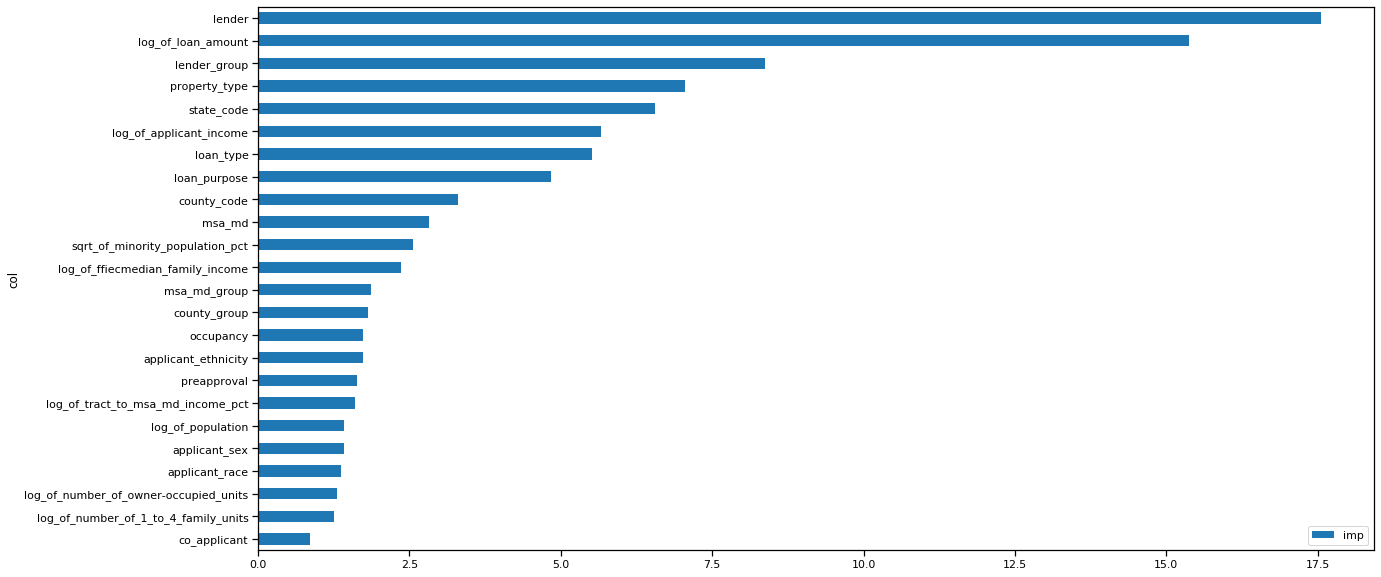

In [143]:
feature_importance(best_model, X_train)

### Prediction and submission of results

In [140]:
predictions = best_model.predict(X_test)

In [141]:
submission = pd.DataFrame(data=predictions, columns=['rate_spread'])
submission['row_id'] = test['row_id']

In [142]:
header = ['row_id','rate_spread']
submission.to_csv('predicting_mortgage_rates_FINAL.csv', columns=header, index=False)